In [1]:
# all import statements 

import logging
logger = logging.getLogger()
logger.setLevel('DEBUG')
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
from concurrent import futures
from itertools import combinations, chain, permutations, product
import json
import networkx as nx
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from urllib.parse import urlparse
import datetime

# importing own modules
import comment_thread as ct
import author_network as an
import multi_comment_thread as mct

SBSTYLE = 'seaborn-notebook'

In [2]:
# functions to create DataFrame with all data for single project
def create_project_frame(project, titles, split):
    """Creates empty DataFrame with MultiIndex for index and columns
    Arguments: project-name, list of thread-titles, split(True/False)
    Return: DataFrame, list of indices for the threads"""
    indices = list(range(1, len(titles)+1))
    if split:
        cols_0 = 5*['basic'] +\
                 10*['all threads'] +\
                 10*['research threads'] +\
                 10*['discussion threads']
        cols_1 = ['title', 'url', 'blog', 'research',  'thread'] +\
                 3*['mthread (single)','mthread (accumulated)',
                    'number of comments', 'number of comments (accumulated)',
                    'network',
                    'authors', 'number of authors', 'authors (accumulated)',
                    'comment_counter', 'comment_counter (accumulated)']
        assert len(cols_0) == len(cols_1)
        cols = pd.MultiIndex.from_arrays([cols_0, cols_1])
    else:
        cols = pd.MultiIndex.from_arrays([cols_0[:15], cols_1[:15]])
    rows = pd.MultiIndex.from_tuples([(project, i) for i in indices],
                                               names=['Project', 'Ord'])
    return DataFrame(index=rows, columns=cols), indices

In [3]:
def split_thread_types(pm_frame):
    """Fills the additional columns for research and discussion threads.
    Argument: DataFrame with intended columns.
    Return: DataFrame with additional data"""
    r_indices = pm_frame[pm_frame['basic', 'research']].index
    d_indices = pm_frame[~pm_frame['basic', 'research']].index
    r_threads = pm_frame[pm_frame['basic', 'research']]['basic', 'thread']
    d_threads = pm_frame[~pm_frame['basic', 'research']]['basic', 'thread']
    pm_frame['research threads', 'mthread (single)'] = pm_frame[pm_frame['basic', 'research']]['all threads', 'mthread (single)']
    pm_frame['research threads', 'mthread (accumulated)'] = Series([mct.MultiCommentThread(*r_threads[0:i+1]) for i in r_indices.droplevel()],
                                                 index=r_indices)
    pm_frame['research threads', 'network'] = pm_frame['research threads', 'mthread (accumulated)'].dropna().apply(an.AuthorNetwork)
    pm_frame['discussion threads', 'mthread (single)'] = pm_frame[~pm_frame['basic', 'research']]['all threads', 'mthread (single)']
    pm_frame['discussion threads', 'mthread (accumulated)'] = Series([mct.MultiCommentThread(*d_threads[0:i+1]) for i in d_indices.droplevel()],
                                                 index=d_indices)
    pm_frame['discussion threads', 'network'] = pm_frame['discussion threads', 'mthread (accumulated)'].dropna().apply(an.AuthorNetwork)
    return pm_frame


In [4]:
def extend_project_frame(pm_frame):
    """Fills the columns with info about comments and authors.
    Argument: DataFrame with intended columns.
    Return: DataFrame with additional data"""
    for thread_type in ['all threads', 'research threads', 'discussion threads']:
        try:
            pm_frame[thread_type, 'number of comments'] = pm_frame[thread_type, 'mthread (single)'].dropna().apply(
                lambda x: len(x.node_name.keys()))
            pm_frame[thread_type, 'number of comments (accumulated)'] = pm_frame[thread_type, 'mthread (accumulated)'].dropna().apply(
                lambda x: len(x.node_name.keys()))
            pm_frame[thread_type, 'authors'] = pm_frame[thread_type, 'mthread (single)'].dropna().apply(
                lambda mthread: set(mthread.author_color.keys()))
            pm_frame[thread_type, 'number of authors'] = pm_frame[thread_type, 'authors'].dropna().apply(
                len)
            pm_frame[thread_type, 'authors (accumulated)'] = pm_frame[thread_type, 'mthread (accumulated)'].dropna().apply(
                lambda mthread: set(mthread.author_color.keys()))
            pm_frame[thread_type, 'comment_counter'] = pm_frame[thread_type, 'mthread (single)'].dropna().apply(
                lambda mthread: Counter(mthread.node_name.values()))
            pm_frame[thread_type, 'comment_counter (accumulated)'] = pm_frame[thread_type, 'mthread (accumulated)'].dropna().apply(
                lambda mthread: Counter(mthread.node_name.values()))
        except KeyError: # when split=False not all thread_types are in pm_frame
            pass
    return pm_frame

In [5]:
def fill_project_frame(pm_frame):
    """forward-fills NaN-values for author/comment-related cols
    Argument: DataFrame with intended columns.
    Return: DataFrame with additional data"""
    for thread_type in ['research threads', 'discussion threads']:
        for data_type in ['number of comments (accumulated)', 'authors (accumulated)', 'comment_counter (accumulated)']:
            pm_frame[thread_type, data_type] = pm_frame[thread_type, data_type].fillna(method='ffill')
    return pm_frame

In [6]:
def process_polymath(project, split=False):
    """Created DataFrame for a given project
    Argument: Project-title.
    Return: DataFrame with additional data"""
    titles, threads = list(zip(*ct.main(
                project.replace("Polymath", "pm"),
                use_cached=False, cache_it=False, merge=False).items()))
    pm_frame, indices = create_project_frame(project, titles, split)
    pm_frame['basic', 'title'] = titles
    pm_frame['basic', 'thread'] = threads
    pm_frame['basic', 'url'] = [thread.data.url for thread in threads]
    pm_frame['basic', 'research'] = [thread.data.is_research for thread in threads]
    pm_frame['basic', 'blog'] = [thread.data.thread_url.netloc.split('.')[0].title() for thread in threads]

    pm_frame['all threads','mthread (single)'] = [mct.MultiCommentThread(thread) for thread in threads]
    pm_frame['all threads','mthread (accumulated)'] = [mct.MultiCommentThread(*threads[0:i+1]) for i in indices]
    pm_frame['all threads','network'] = pm_frame['all threads', 'mthread (accumulated)'].apply(an.AuthorNetwork)
    if split:
        pm_frame = split_thread_types(pm_frame)
    pm_frame = pm_frame.pipe(
        extend_project_frame).pipe(
        fill_project_frame)
    return pm_frame

In [7]:
# creating the DataFrames for all projects
start = datetime.datetime.now()
print("starting at: ", start)
PM1_FRAME = process_polymath("Polymath 1", split=True)
stop = datetime.datetime.now()
print("Polymath 1 processed in ", stop-start)
start = datetime.datetime.now()
PM2_FRAME = process_polymath("Polymath 2", split=True)
stop = datetime.datetime.now()
print("Polymath 2 processed in ", stop-start)
start = datetime.datetime.now()
PM3_FRAME = process_polymath("Polymath 3", split=True)
stop = datetime.datetime.now()
print("Polymath 3 processed in ", stop-start)
start = datetime.datetime.now()
PM4_FRAME = process_polymath("Polymath 4", split=True)
stop = datetime.datetime.now()
print("Polymath 4 processed in ", stop-start)
start = datetime.datetime.now()
PM5_FRAME = process_polymath("Polymath 5", split=True)
stop = datetime.datetime.now()
print("Polymath 5 processed in ", stop-start)
start = datetime.datetime.now()
PM6_FRAME = process_polymath("Polymath 6", split=True)
stop = datetime.datetime.now()
print("Polymath 6 processed in ", stop-start)
start = datetime.datetime.now()
PM7_FRAME = process_polymath("Polymath 7", split=True)
stop = datetime.datetime.now()
print("Polymath 7 processed in ", stop-start)
start = datetime.datetime.now()
PM8_FRAME = process_polymath("Polymath 8", split=True)
stop = datetime.datetime.now()
print("Polymath 8 processed in ", stop-start)
start = datetime.datetime.now()
PM9_FRAME = process_polymath("Polymath 9", split=True)
stop = datetime.datetime.now()
print("Polymath 9 processed in ", stop-start)
start = datetime.datetime.now()
PM10_FRAME = process_polymath("Polymath 10", split=True)
stop = datetime.datetime.now()
print("Polymath 10 processed in ", stop-start)
start = datetime.datetime.now()
PM11_FRAME = process_polymath("Polymath 11", split=True)
stop = datetime.datetime.now()
print("Polymath 11 processed in ", stop-start)
print("completed at: ", datetime.datetime.now())

starting at:  2016-09-01 11:09:27.864134
Polymath 1 processed in  0:01:42.200316
Polymath 2 processed in  0:00:01.605980


Polymath 3 processed in  0:00:29.269366
Polymath 4 processed in  0:00:21.021702


Polymath 5 processed in  0:03:35.365218
Polymath 6 processed in  0:00:06.381202


Polymath 7 processed in  0:00:30.202274


Polymath 8 processed in  0:16:22.027408
Polymath 9 processed in  0:00:18.025157


Polymath 10 processed in  0:00:37.379773


Polymath 11 processed in  0:00:36.678263
completed at:  2016-09-01 11:34:08.022291


In [8]:
# merging all DataFrames in a single frame
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME, PM9_FRAME, PM10_FRAME, PM11_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]

In [9]:
ALL_AUTHORS = set.union(*PM_FRAME['all threads', 'authors'].tolist())

In [10]:
# utility-functions to get specific parts of PM_FRAME
def get_last(thread_type):
    """thread_type is either 'all threads', 'research threads', or 'discussion threads'
    Returns tuple of:
    (1) DataFrame with only last row for each project
    (2) List of positions for last rows DataFrame"""
    source = PM_FRAME[['basic', thread_type]].dropna() if thread_type else PM_FRAME
    projects = source.index.droplevel(1).unique()
    ords = [source.loc[project].index[-1] for project in projects]
    lasts_index = pd.MultiIndex.from_tuples(list(zip(projects, ords)),names=['Project', 'Ord'])
    data = source.loc[lasts_index]
    return data, lasts_index

def get_project_at(project, thread_type, stage):
    if stage == -1:
        logging.info("Stage is last non-null stage of %s", project)
        out = PM_FRAME.loc[project][thread_type].dropna().iloc[stage]
    else:
        out = PM_FRAME.loc[project][thread_type].iloc[stage]
        nulls = pd.isnull(out)
        if np.any(nulls):
            logging.warning("Some empty values: %s", out.index[nulls])
    return out

In [11]:
# wrappers for mthread-methods
def plot_activity_author(project,
                         thread_type="all threads", stage=-1,
                         intervals=1):
    """Wrapper function for mthread.plot_activity_author
    Plots author activity over time for project (limited to thread_type)"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.plot_activity_author(project=project,
                              intervals=intervals)

def plot_activity_thread(project,
                         thread_type="all threads", stage=-1,
                         color_by="cluster",
                         intervals=1):
    """Wrapper function for mthread.plot_activity_thread
    Plots thread activity over time for project (limited to thraead_type).
    color_by is either cluster or author"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.plot_activity_thread(project=project,
                              color_by=color_by,
                              intervals=intervals)

def plot_discussion_tree(project, thread_type="all threads", intervals=10, stage=-1):
    """Wrapper function for mthread.draw_graph
    Plots structure of discussion in project"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.draw_graph(project=project,
                    intervals=intervals)

# could be extended to single mthreads to look at growth of single threads
def plot_growth(project,
                thread_type="all threads", stage=-1):
    """Wrapper function for mthread.plot_growth
    Plots growth in comments in discussion"""
    data = get_project_at(project, thread_type, stage)['mthread (accumulated)']
    data.plot_growth(project=project)

In [12]:
# wrapper-functions for author_network plotting-methods
def plot_activity_pie(project,
                      thread_type="all threads", stage=-1,
                      what='total comments'):
    """Wrapper function for author_network.plot_author_activity_pie
    Plots pie-chart of comment_activity of commenters is project.
    'what' can be 'total comments', or 'word counts'"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_author_activity_pie(project=project,
                                  what=what)
    
def plot_activity_bar(project,
                      thread_type="all threads", stage=-1,
                      what="by level",
                      fontsize=6):
    """Wrapper function for author_network.plot_activity_bar
    Plots bar-chart of comment_activity of commenters in project
    'what' can be 'by level' or 'word counts'"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_author_activity_bar(project=project,
                                  what=what,
                                  fontsize=fontsize)

def plot_activity_prop(project,
                       thread_type="all threads", stage=-1,
                       fontsize=6):
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_activity_prop(project=project)

def plot_activity_degree(project,
                         thread_type="all threads", stage=-1,
                         graph_type='interaction',
                         measures=None,
                         delete_on=None, thresh=0,
                         fontsize=6):
    """Wrapper function for author_network.plit_activity_degree
    Plots superposition of bar-chart of comment-activity and line-chart of degree-centrality"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_activity_degree(project=project,
                              g_type=graph_type,
                              measures=measures,
                              delete_on=delete_on, thresh=thresh,
                              fontsize=fontsize)

def plot_centrality_measures(project,
                         thread_type="all threads", stage=-1,
                         graph_type='interaction',
                         measures=None,
                         delete_on=None, thresh=0,
                         fontsize=6):
    """Wrapper function for author_network.plot_activity_degree
    Plots superposition of bar-chart of comment-activity and line-chart of degree-centrality"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_centrality_measures(project=project,
                              g_type=graph_type,
                              measures=measures,
                              delete_on=delete_on, thresh=thresh,
                              fontsize=fontsize)

def plot_comment_histogram(project,
                          thread_type="all threads", stage=-1,
                          what="total comments", bins=10,
                          fontsize=6):
    """Wrapper function for author_network.plot_author_activity_hist.
    'what' is either 'total comments' or 'word counts'"""
    data = get_project_at(project, thread_type, stage)['network']
    data.plot_author_activity_hist(project=project,
                                   what=what, bins=bins,
                                   fontsize=fontsize)

In [13]:
# wrapper function for correlation between network-measures in author_network
def measures_corr(project, graph_type, thread_type="all threads", stage=-1):
    data = get_project_at(project, thread_type, stage)['network']
    return data.corr_centrality_measures(project=project, g_type=graph_type)

In [17]:
# wrappers for network-drawing methods of author_network
def draw_network(project, graph_type, thread_type="all threads", reset=False, stage=-1):
    """Wrapper function for author_network.draw_graph.
    Plots the interaction-network between the commenters in project."""
    get_project_at(project, thread_type, stage)['network'].draw_graph(project=project, graph_type=graph_type, reset=reset)
    
def draw_centre(project, thread_type="all threads", stage=-1, show=False, skips=10, zoom=1):
    """Wrapper function for author_network.draw_centre_discussion"""
    get_project_at(project, thread_type, stage)['network'].draw_centre_discussion(show=show, skips=skips, zoom=zoom)



In [18]:
def plot_community_evolution(project, thread_type):
    """thread_type is 'all threads', 'research threads', or 'discussion threads'"""
    if not thread_type:
        logging.warning("Need explicit thread type")
        return
    try:
        int(project.split()[-1])
        as_threads = True
    except ValueError:
        as_threads = False
    if as_threads:
        data = PM_FRAME[['basic', thread_type]].loc[project].dropna()
        added = (data[thread_type, 'authors'] - data[thread_type, 'authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data[thread_type, 'authors'].shift(1) - data[thread_type, 'authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data[thread_type, 'authors'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"], index=data.index)
        df.index = range(len(df))
        try:
            assert np.all(df == df.dropna())
        except AssertionError:
            logging.warning("Some nan-values still present")
        df.index.name = "Threads"
    else:
        data, positions = get_last(thread_type)
        added = (data[thread_type, 'authors (accumulated)'] - data[thread_type, 'authors (accumulated)'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data[thread_type, 'authors (accumulated)'].shift(1) - data[thread_type, 'authors (accumulated)']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data[thread_type, 'authors (accumulated)'].dropna().apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"])
        df.index = list(range(1, len(positions) + 1))
    matplotlib.style.use(SBSTYLE)
    axes = df.plot(kind="area", title="Community Evolution in {} ({})".format(project, thread_type),
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes.set_xticks(df.index)
    if as_threads:
        axes.set_xticklabels(data['basic', 'title'], rotation=90, fontsize='small')
    else:
        xlabels = data.index.droplevel(1)
        axes.set_xticklabels(xlabels, rotation=90, fontsize='small')
    axes.set_ylabel('number of active commenters')

In [19]:
def project_participation_evolution(n=2, skip_anon=True, research_only=False):
    if not research_only:
        thread_type = 'all threads'
        data, _ = get_last(thread_type)
        all_authors = list(ALL_AUTHORS)
        title = "Participation per project in Polymath (threshold = {})".format(n)
    else:
        thread_type = 'research threads'
        data, _ =  get_last(thread_type)
        all_authors = set().union(*data['research threads', 'authors (accumulated)'])
        title = "Participation per project in Polymath (threshold = {}, only research-threads)".format(n)
    data.index = data.index.droplevel(1)
    author_project = DataFrame(columns=all_authors)
    for author in author_project.columns:
        author_project[author] = data[thread_type, 'authors (accumulated)'].apply(lambda project: author in project)
    author_project = author_project.T
    author_project = author_project.sort_values(by=data.index.tolist(), ascending=False)
    author_project = author_project.drop("Anonymous") if skip_anon else author_project
    select = author_project.sum(axis=1) >= n
    return author_project, data.index, select, title

def thread_participation_evolution(project, n=2, skip_anon=True, research_only=False):
    if not research_only:
        thread_type = 'all threads'
        title = "Participation per thread in {} (threshold = {})".format(project, n)
    else:
        thread_type = 'research threads'        
        title = "Participation per thread in {} (threshold = {}, only research-threads)".format(project, n)
    data = PM_FRAME.loc[project][['basic', thread_type]]
    data = data.dropna()
    all_authors = set().union(*data[thread_type, 'authors'])
    author_thread = DataFrame(columns=all_authors)
    for author in author_thread.columns:
        author_thread[author] = data[thread_type, 'authors'].apply(lambda thread: author in thread)
    author_thread = author_thread.T
    author_thread = author_thread.sort_values(by=data.index.tolist(), ascending=False)
    author_thread = author_thread.drop("Anonymous") if skip_anon else author_thread
    author_thread.columns.name = "Threads"
    select = author_thread.sum(axis=1) >= n
    return author_thread, data.index, select, title

def plot_participation_evolution(author_project, indices, select, title, fontsize=8):
    matplotlib.style.use(SBSTYLE)
    factor = 30 - len(indices) if len(indices) <= 30 else 40 - len(indices)
    colors = [plt.cm.Set1(factor*i) for i in range(len(indices))]
    author_project.loc[select].plot(kind="bar", stacked=True, color=colors,
                                    title=title, fontsize=fontsize)

In [20]:
def general_heatmap(authors=None, binary=False, thread_type='all threads', thread_level=True,
                    binary_method='average', method='ward'):
    if thread_level:
        authors_filtered = list(ALL_AUTHORS)
        try:
            authors_filtered.remove("Anonymous")
        except:
            pass
        data=PM_FRAME[thread_type, 'comment_counter']
    else:
        authors_filtered = list(ALL_AUTHORS) if not authors else authors 
        try:
            authors_filtered.remove("Anonymous")
        except:
            pass
        data = get_last(thread_type)[0][thread_type, 'comment_counter (accumulated)']
    if binary:
        as_matrix=np.array([[True if author in data[thread] else False for author in authors_filtered]
                        for thread in data.index])
        Z_author = linkage(as_matrix.T, method=binary_method, metric='hamming')
        Z_thread = linkage(as_matrix, method=binary_method, metric='hamming')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        #print("Cophenetic Correlation Coefficient with {}: {}".format(binary_method, c))
    else:
        as_matrix = []
        for thread in data.index:
            new_row = [data.loc[thread][author] for author in authors_filtered]
            as_matrix.append(new_row)
        as_matrix = np.array(as_matrix)
        Z_author = linkage(as_matrix.T, method=method, metric='euclidean')
        Z_thread = linkage(as_matrix, method=method, metric='euclidean')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        #print("Cophenetic Correlation Coefficient with {}: {}".format(method, c))
    # compute dendogram and organise DataFrame
    ddata_author = dendrogram(Z_author, color_threshold=.07,
                              no_plot=True)
    ddata_thread = dendrogram(Z_thread, color_threshold=.07, no_plot=True)
    df = DataFrame(as_matrix, columns=authors_filtered)
    cols = [authors_filtered[i] for i in ddata_author['leaves']]
    df = df[cols]
    rows = [df.index[i] for i in ddata_thread['leaves']]
    df = df.reindex(rows)
    title = "Project-Engagement in Polymath ({})".format(thread_type)
    return df, binary, title


def plot_heatmap(df, binary, title, log=True, fontsize=8):
    # start setting up plots
    matplotlib.style.use(SBSTYLE)
    fig, ax_heatmap = plt.subplots()
    # plot heatmap
    heatmap = ax_heatmap.pcolor(df,
                        edgecolors='w',
                        cmap=mpl.cm.binary if binary else mpl.cm.GnBu,
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax_heatmap.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax_heatmap.set_aspect('equal')  # ensure heatmap cells are square
    ax_heatmap.xaxis.set_ticks_position('bottom')  # put column labels at the bottom
    ax_heatmap.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    ax_heatmap.set_title(title)
    
    ax_heatmap.set_yticks(np.arange(0.5, len(df.index)+.5, 1))
    ax_heatmap.set_yticklabels(df.index + 1, fontsize=fontsize)
    ax_heatmap.set_xticks(np.arange(len(df.columns)) + 0.5)
    ax_heatmap.set_xticklabels(df.columns, rotation=90, fontsize=fontsize)
    
    if not binary:
        divider_h = make_axes_locatable(ax_heatmap)
        cax = divider_h.append_axes("right", "3%", pad="1%")
        plt.colorbar(heatmap, cax=cax)
        
    lines = (ax_heatmap.xaxis.get_ticklines() +
             ax_heatmap.yaxis.get_ticklines())
    plt.setp(lines, visible=False)
    
    plt.tight_layout()

In [21]:
def project_heatmap(project, binary=False, thread_type='all threads', cluster_threads = True,
                    method='ward', binary_method='average',
                    skip_anon=True, log=False, fontsize=8):
    """
    Plots clustered heatmaps of thread-participation per author.
    Based on: https://gist.github.com/s-boardman/cef9675329a951e89e93
              https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    """
    data = PM_FRAME[thread_type].loc[project].copy()
    all_authors = sorted(list(data.iloc[-1]['authors (accumulated)']))
    if skip_anon:
        try:
            all_authors.remove("Anonymous")
        except ValueError:
            pass
    data = data['comment_counter']
    title = "Participation per thread in " + project
    if binary:
        as_matrix=np.array([[True if author in data[thread] else False for author in all_authors]
                        for thread in data.index])
        Z_author = linkage(as_matrix.T, method=binary_method, metric='hamming')
        if cluster_threads:
            Z_thread = linkage(as_matrix, method=binary_method, metric='hamming')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        print("Cophenetic Correlation Coefficient with {}: {}".format(binary_method, c))
    else:
        as_matrix = []
        for thread in data.index:
            new_row = [data.loc[thread][author] for author in all_authors]
            as_matrix.append(new_row)
        as_matrix = np.array(as_matrix)
        Z_author = linkage(as_matrix.T, method=method, metric='euclidean')
        if cluster_threads:
            Z_thread = linkage(as_matrix, method=method, metric='euclidean')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        print("Cophenetic Correlation Coefficient with {}: {}".format(method, c))
    ddata_author = dendrogram(Z_author, color_threshold=.07, no_plot=True)
    df = DataFrame(as_matrix, columns=all_authors)
    cols = [all_authors[i] for i in ddata_author['leaves']]
    df = df[cols]
    if cluster_threads:
        ddata_thread = dendrogram(Z_thread, color_threshold=.07, no_plot=True)
        rows = [df.index[i] for i in ddata_thread['leaves']]
        df = df.reindex(rows)
    matplotlib.style.use('seaborn-poster')
    fig, ax = plt.subplots(1,1)
    heatmap = ax.pcolor(df,
                        edgecolors='k' if binary else 'w',
                        cmap=mpl.cm.binary if binary else mpl.cm.GnBu,
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax.set_aspect('equal')  # ensure heatmap cells are square
    ax.xaxis.set_ticks_position('bottom')  # put column labels at the bottom
    ax.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    ax.set_title("Thread-participation in {}".format(project))
    
    plt.yticks(np.arange(len(df.index)) + 0.5, df.index, fontsize=fontsize)
    plt.xticks(np.arange(len(df.columns)) + 0.5, df.columns, rotation=90, fontsize=fontsize)
    
    if not binary:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", "3%", pad="1%")
        plt.colorbar(heatmap, cax=cax)
    
    plt.tight_layout()

In [22]:
def plot_thread_evolution(project, compress=1, sel=[], sharex=True):
    # data for evolution
    thread_type='all threads'
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    added = (data[thread_type, 'authors'] - data[thread_type, 'authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
    removed = (data[thread_type, 'authors'].shift(1) - data[thread_type, 'authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
    size = data[thread_type, 'number of authors'] - added
    df1 = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                   columns=["joined", "current", "left"], index=data.index)
    df1.index.name = ""
    # data for engagement
    engagement = {}
    for thread_type in ['all threads', 'research threads', 'discussion threads']:
        engagement[thread_type] = data[thread_type, 'number of authors'] / data[thread_type, 'number of comments']
    df2 = DataFrame(engagement, index=data.index)
    sizes = (data['all threads', 'number of comments'] / compress).tolist()
    df2.index.name = ""
    df2_max=df2['all threads'].max()
    all_mean=df2['all threads'].mean()
    res_mean=df2['research threads'].mean()
    disc_mean=df2['discussion threads'].mean()
    # setting up plot
    matplotlib.style.use('seaborn-talk')
    fig, axes = plt.subplots(2, 1, figsize=(15, 6), squeeze=False, sharex=sharex)
    plt.subplots_adjust(hspace=0.2)
    # plot bottom
    df1.plot(kind="area", ax = axes[1][0], title="",
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes[1][0].set_ylabel('active commenters')
    axes[1][0].legend(bbox_to_anchor=(1.14, 1))
    # plot top
    df2[['research threads', 'discussion threads']].plot(kind='bar', ax = axes[0][0], color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes[0][0].set_ylabel('comments per participant')
    axes[0][0].set_yticklabels([round(1/i, 2) for i in axes[0][0].get_yticks()])
    axes[0][0].yaxis.get_major_ticks()[0].label1.set_visible(False)
    axes[0][0].get_xaxis().set_ticks([])
    axes[0][0].set_xlabel("")
    xlims = (0.5,len(df1.index)+.5)
    axes[0][0].set_xlim(xlims)
    axes[0][0].set_ylim(0, df2_max*1.1)
    axes[0][0].legend(bbox_to_anchor=(1.23, 1))
    axes[0][0].lines.append(
        mpl.lines.Line2D(list(xlims), [all_mean, all_mean], linestyle = '--', linewidth = .5, color = 'Blue', zorder = 1, transform = axes[0][0].transData))
    axes[0][0].lines.append(
        mpl.lines.Line2D(list(xlims), [res_mean, res_mean], linestyle = '-', linewidth = .5, color = 'lightsteelblue', zorder = 1, transform = axes[0][0].transData))
    axes[0][0].lines.append(
        mpl.lines.Line2D(list(xlims), [disc_mean, disc_mean], linestyle = '-', linewidth = .5, color = 'steelblue', zorder = 1, transform = axes[0][0].transData))
    for container in axes[0][0].containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df2.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    all_threads = data['all threads'][['number of comments', 'number of authors']]
    for i in list(set(sel).intersection(data.index)):
            axes[0][0].text(
                i + .25,
                df2.loc[i, 'all threads']+.01,
                "{} comments\n {} commenters".format(
                    all_threads.loc[i,'number of comments'],
                    all_threads.loc[i, 'number of authors']),
                ha="center", va="bottom", fontsize='small')

**To Do: add feature to get first and last from info in PM_FRAME**

# Introduction
Within the philosophy of mathematical practice the Polymath projects, the online collaborative projects initiated by Timothy Gowers, have since their start in 2009 attracted visible attention <cite data-cite="763884/WXE3J6GJ"></cite>, <cite data-cite="763884/RXTHUZGM"></cite>, <cite data-cite="763884/ICNJ8I5P"></cite>. As the philosophy of mathematical practice is concerned with how mathematics is done, evaluated, and applied, this interest should barely surprise us. The research-activity within Polymath was carried out publicly on several blogs, and thus led to the creation of a large repository of interactive mathematical practice in action: a treasure of information ready to be explored. In addition, the main players in this project (the Field-medallists Timothy Gowers and Terrence Tao) continuously reflected on the enterprise, and provided additional insight on the nature of mathematical research, and large-scale collaboration <cite data-cite="763884/QSM6KVB6"></cite> §2. This led amongst others to the claim that the online collective problem solving that underpins the Polymath-projects consists of “mathematical research in a new way” <cite data-cite="763884/TVHHE2TD"></cite>: 879.

The upshot of our inquiry is to improve on prior in-depth examinations of the Polymath projects (<cite data-cite="barany2010b">Barany 2010</cite>, <cite data-cite="Cranshaw:ConfHumFactComputSystProcConference:2011">Cranshaw & Kittur 2011</cite>, **Paterson et al. 2011**, <cite data-cite="Varshney 2012">Varshney 2012</cite>, and <cite data-cite="pease2012seventy">Pease & Martin 2012</cite>) by taking advantage of the fact that we can now look back on 11 Polymath-projects (apart from <cite data-cite="Ball2014">Ball 2014</cite> and Franzonia & Sauermann 2014, most analysis and discussion focused either on the first project, or on one of the smaller *mini* projects), two of which only started within the last year, and by relying on scholarship on e-research and citizen science that isn't typically part of the theoretical background that the philosophy of mathematical practice builds on. Specifically, we wish to:

1.	Rely on more data, and hence look beyond the intial succes and broad appeal of Polymath 1 and try to indentify long-term features of Polymath. Such features may concern the *ad hoc* community created by the Polymath projects, but also the patterns of collaboration that are arise as “weblog mathematics” becomes more mature, or the question of what Polymath is crowdsourcing (pieces of mathematical proofs, ideas and insights, or the community itself).

2.	Put Polymath in context by building on the social study of e-research, crowd-science and citizen science, and answer questions regarding the scale of the Polymath projects, the role of technology, and the division of labour between the organisers and the participants to the Polymath projects by contrasting our data and insights with available data and insights on other online collaborative scientific enterprises that have been studied.

3. Engage with the literature on the structure of scientific communities that has been developed within (formally oriented) social epistemology and the philosophy of science, and contribute to the current debate on how we should provide an empirical grounding for the *a priori* methods (e.g. simulations based on simplified models of scientific communities). 

With most weight placed on the first two items, and the third item relegated to a dedicated study based on the same empirical material.

Notwithstanding our reliance on online research methods, our final intent is still to contribute to the philosophy of mathematical practices by adopting a sociological approach and relying on empirical data. This approach is not without risks.

First, we still need to ensure that the perspective we adopt allows us to answer the questions **to be completed**

Second, there is a kind of paradox **to be completed**

## Overview of the paper

1. Polymath: an informal overview
2. Polymath in perspective
    1. e-research, crowd-science and citizen science
    2. The role of ICT's
3. A network-analysis of the Polymath-projects
4. Polymath as a scientific community
5. Investigating individual projects
    1. Polymath 1
    2. One of the standard projects (3,4 or 5)
    3. Polymath 8

# Polymath: an informal overview

The story of how Polymath started has been retold in many places, including reports by the leading figures <cite data-cite="Gowers:Nature:2009">(Gowers 2009)</cite>, <cite data-cite="Gowers:AnIrregularMind:2010">(Gowers 2010)</cite>, and <cite data-cite="Nielsen:ReinventingDiscoveryTheNewEraOf:2012">(Nielsen 2012)</cite>, in the popular science press (New Scientist: “Mathematics becomes more sociable”, “How to build the global mathematics brain”.), and within the philosophy of mathematical practices <cite data-cite="VanBendegem:MathematicsAndTheNewTechnologiesPartIii:">(Van Bendegem 2011)</cite>.

We do not need to repeat this story in full detail, but only quote briefly from Gower's [“Is massively collaborative mathematics possible?”](https://gowers.wordpress.com/2009/01/27/is-massively-collaborative-mathematics-possible/) blog-post that launched the idea and described the intended model of collaboration:

> It seems to me that, at least in theory, a different model could work: different, that is, from the usual model of people working in isolation or collaborating with one or two others. Suppose one had a forum (in the non-technical sense, but quite possibly in the technical sense as well) for the online discussion of a particular problem. The idea would be that anybody who had anything whatsoever to say about the problem could chip in. And the ethos of the forum — in whatever form it took — would be that comments would mostly be kept short. In other words, what you would not tend to do, at least if you wanted to keep within the spirit of things, is spend a month thinking hard about the problem and then come back and write ten pages about it. Rather, you would contribute ideas even if they were undeveloped and/or likely to be wrong.

and also suggested why *blog-mathematics* might be a good idea:

> Here is where the beauty of blogs, wikis, forums etc. comes in: they are completely public, as is their entire history. To see what effect this might have, imagine that a problem was being solved via comments on a blog post. Suppose that the blog was pretty active and that the post was getting several interesting comments. And suppose that you had an idea that you thought might be a good one. Instead of the usual reaction of being afraid to share it in case someone else beat you to the solution, you would be afraid not to share it in case someone beat you to that particular idea. And if the problem eventually got solved, and published under some pseudonym like Polymath, say, with a footnote linking to the blog and explaining how the problem had been solved, then anybody could go to the blog and look at all the comments. And there they would find your idea and would know precisely what you had contributed. There might be arguments about which ideas had proved to be most important to the solution, but at least all the evidence would be there for everybody to look at.

Prior scholarship devoted to the Polymath-projects can be organised in three disciplinary categories.
A first category is dedicated toi how specific information-technologies are used for collaboration, and can naturally by related to hypertext research (in particular the use of blogs and wiki's) and humanistic computing. This category includes the above-mentioned work of Barany, Cranshaw & Kittur, and Varshney. The authors of these papers try to identify specific features of how collaboration in the Polymath-projects proceeds (e.g. remarks on noise-to-signal ratio by Barany, or the importance of leadership by Barany and Cranshaw & Kittur), propose criteria for success, and seek to evaluate to what extent collaboration in Polymath is successful. Unlike the present paper, the focus in this work is limited to the first Polymath-project. By contrast, it relies on social science methodology, and network-analysis in particular, as will be done in the present paper.

A second category squarely belongs to the philosophy of mathematical practice. This includes work by Martin and Pease, with its emphasis on problem-solving and argumentation in mathematics (influenced by Lakatos, Pólya, and by work in formal argumentation), and focus on the use of ICT's in mathematics that relates to the metaphor of *social machines*. Specifically, they analysed the third mini-Polymath project (see also below) and identified categories of comments and the mathematical concepts they relied on, and developed a typology of questions based on a sample of questions asked on MathOverflow (the research-mathematics site of StackExchange). Previous work by the present authors also belongs to this category. Finally, though not explicitly part of the philosophy of mathematical practice, **Patterson et al.** have also drawn attention to the value of Polymath as a record that publicly exposes the intermediate stages of research and hence reveals how mathematical inquiry (and collaboration) proceeds, and to the possibility of applying network-science to study the development of these projects.

In the third category we find insider and popular science press reports on Polymath, which were the decisive element in how Polymath gained notoriety, and include in the first place Gowers and Nielsen's opinion piece in Nature <cite data-cite="Gowers:Nature:2009">Gowers & Nielsen 2009</cite> and Nielsen's “Reinventing Discovery: the New Era of Networked Science” in which Polymath featured prominently <cite data-cite="Nielsen:ReinventingDiscoveryTheNewEraOf:2012">Nielsen 2012</cite>. Additional inside-reports include <cite data-cite="Nielsen2010">Nielsen 2010</cite> (though Nielsen describes himself as an “interested outsider”, p. 651 *op. cit*) and <cite data-cite="Gowers:AnIrregularMind:2010">Gowers 2010</cite> which covered the problem solved in the first Polymath-project, the views about collaboration in mathematics that motivated the project, and lessons learned from organising and guiding a large collaborative project. Finally, articles in [New Scientist](https://www.newscientist.com/article/mg21028113-900-how-to-build-the-global-mathematics-brain/) (<cite data-cite="aron2011build">Aron 2011</cite>), Scientific American (<cite data-cite="castelvecchi2010problem">Castelvecchi 2010</cite>), The Mathematical Intelligencer (<cite data-cite="Nathanson">Nathanson 2010</cite>), a more recent short piece in Nature by Philip Ball (<cite data-cite="Ball2014">Ball 2014</cite>), and many blog-posts complete this category.

In addition to these three categories, the Polymath-projects are also addressed in the more general literature on e-research and crowd-science. Section 3 is entirely devoted to this aspect of Polymath.

Since its start in early 2009, 11 full Polymath projects were started, and 4 smaller, so-called Mini-Polymath, projects were started. We focus here on the former group, dedicated to research-problems, and leave the latter (based on questions from the Mathematics Olympiad Finals) aside **(but see Martin & Pease, and Patterson et al.)**. Of these projects, 3 were unambiguously succesfull (1, 4, and 8) and led to published results, whereas another one led to insights that were used in published work (5). Whereas the two most recent projects can still be considered active, and Polymath 2 (failed attempts to revive) and Polymath 9 (which turned out to be based on mistaken assumptions) can be considered as closed, the status of remaining projects is harder to determine.

Already during the first project the discussion was not limited to a single blog, and Polymath-projects have since been conducted on 5 different blogs. A general overview of the projects, as well as summaries of background-material and progress is collected in a dedicated [Wiki](http://www.michaelnielsen.org/polymath1/index.php?title=Main_Page) hosted by Michael Nielsen. The main Polymath-blog also serves as a hub to announce new initiatives, and crowdsource ideas for future projects. Such hubs are no doubt essential given how Polymath-efforts and initiatives are distributed, and given their openness to new initiatives. In September 2015 Gil Kalai also created a [question](http://mathoverflow.net/questions/219638/proposals-for-polymath-projects) on MathOverflow (the StackExchange community for professional mathematicians) devoted to new Polymath-proposals. This serves again as a new hub, and takes advantage of the more elaborate platform, especially the ability to vote proposals up or down, offered by StackExchange.  

A brief overview of the projects is included below:


|Project | Title | Start| Status |
|--------|-------|------| ------ |
| Polymath1 | “New proofs and bounds for the density Hales-Jewett theorem.” | Initiated Feb 1, 2009 | research results have now been published.|
| Polymath2 | “Must an “explicitly defined” Banach space contain c_0 or l_p?” | Initiated Feb 17, 2009 | attempts to relaunch via wiki, June 9 2010.|
| Polymath3 | “The polynomial Hirsch conjecture.” | Proposed July 17, 2009; launched, September 30, 2010.| Undecided |
| Polymath4 | “A deterministic way to find primes.” | Proposed July 27, 2009; launched Aug 9, 2009 | Research results have now been published.|
| Polymath5 | “The Erdős discrepancy problem.” | Proposed Jan 10, 2010; launched Jan 19, 2010 | Activity ceased by the end of 2012, but results from the project were used to solve the problem in 2015.|
| Polymath6 | “Improving the bounds for Roth's theorem.” | Proposed Feb 5, 2011 | Partial result published by non-participant|
| Polymath7 | “Establishing the Hot Spots conjecture for acute-angled triangles.” | Proposed, May 31st, 2012; launched, Jun 8, 2012.| Undecided |
| Polymath8 | “Improving the bounds for small gaps between primes.” | Proposed, June 4, 2013; launched, June 4, 2013. | Research results have now been published.|
| Polymath9 | “Exploring Borel determinacy-based methods for giving complexity bounds.” | Proposed, Oct 24, 2013; launched, Nov 3, 2013 | “success of a kind”.|
| Polymath10 | “Improving the bounds for the Erdos-Rado sunflower lemma.” | Launched, Nov 2, 2015 | ongoing|
| Polymath11 | “Proving Frankl's union-closed conjecture.” | Proposed Jan 21, 2016; launched Jan 29, 2016 | ongoing|

The reach and size of each of these projects varied considerably. The plot below summarises the number of participants and comments for each project. Many of the projects are organised in separate research-threads limited to discussing how a given mathematical problem could be solved and discussion-threads devoted to meta-aspects and reflections on both the problem and the process of collaboration. As it quickly became clear that both types of threads proceeded differently, this first figure already takes this distinction into account. 

In [23]:
THE_DATA, _ = get_last(None)
THE_DATA.index= THE_DATA.index.droplevel(1)
THE_DATA.columns = THE_DATA.columns.swaplevel()
AUTHOR_DATA = THE_DATA['authors (accumulated)'].copy()
COMMENT_DATA = THE_DATA['number of comments (accumulated)', 'all threads'].copy()
AUTHOR_DATA['authors only active in research threads'] = AUTHOR_DATA['research threads'] - AUTHOR_DATA['discussion threads']
AUTHOR_DATA['authors only active in "discussion" threads'] = AUTHOR_DATA['discussion threads'] - AUTHOR_DATA['research threads']
AUTHOR_DATA['authors active in both types of threads'] = AUTHOR_DATA['all threads'] - AUTHOR_DATA['authors only active in research threads'] - AUTHOR_DATA['authors only active in "discussion" threads']
for project in AUTHOR_DATA.index:
    if pd.isnull(AUTHOR_DATA.loc[project]['authors only active in research threads']):
        AUTHOR_DATA.loc[project]['authors only active in research threads'] = AUTHOR_DATA.loc[project]['all threads']
AUTHOR_DATA = AUTHOR_DATA[['authors only active in research threads', 'authors active in both types of threads', 'authors only active in "discussion" threads']]
AUTHOR_DATA = AUTHOR_DATA.applymap(lambda set: len(set) if pd.notnull(set) else 0)

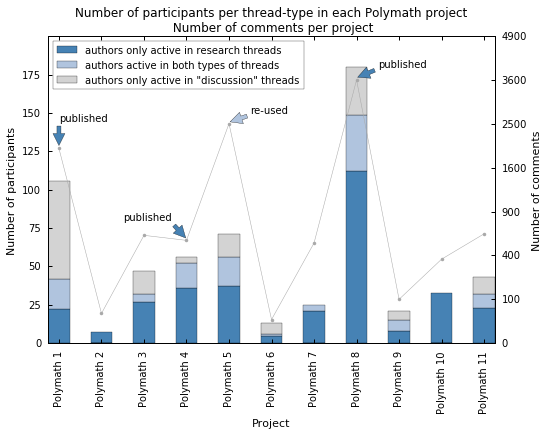

In [24]:
matplotlib.style.use(SBSTYLE)
axes = plt.subplot()
AUTHOR_DATA.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'], ax=axes,
          title="Number of participants per thread-type in each Polymath project\n Number of comments per project")
axes.set_ylabel("Number of participants")
axes.set_ylim(0,200)
axes.set_yticks(range(0,200,25))
axes.annotate('published', xy=(0, 128), xytext=(0, 145),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('published', xy=(3, 68), xytext=(1.5, 80),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('re-used', xy=(4, 144), xytext=(4.5, 150),
            arrowprops=dict(facecolor='lightsteelblue', shrink=0.05),
            )
axes.annotate('published', xy=(7, 173), xytext=(7.5, 180),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
COMMENT_DATA = np.sqrt(COMMENT_DATA)
axes2 = axes.twinx()
axes2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:"{:0.0f}".format(np.square(x))))
axes2.set_ylabel("Number of comments")
_ = axes2.plot(axes.get_xticks(), COMMENT_DATA.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')

Based on the total number of participants, the first Polymath-project is remains exceptional as the project with the second highest number of participants (only Polymath 8, an outlier in many respects, attracted more participants), and, especially, as the project with the broadest appeal. More than half of the Polymath 1 participants were only active in the discussion-threads, and hence presumably constituted a following that  exceeded the intended audience of mathematicians with the required expertise. If we only look at participants to research-threads, we see that most projects that unambiguously *took of* (i.e. generated more than 100 comments) attracted approximately between 25 and 56 participants, whereas Polymath 8 attracted almost 3 times as many participants (149).

We delay a further discussion of facts and figures until we've described our methodology.

# Polymath in perspective

## e-research, crowd-science and citizen science
The Polymath-projects clearly fit the definition of e-research as research based on the use of digital tools and data—and the internet in particular—for the distributed and collaborative production of knowledge (Meyer and Schroeder 2015 chapt. 1). Because it makes project-participation and access to intermediate inputs entirely open, it also qualifies as a type of crowd-science as conceived in Franzoni & Sauermann 2014 (see especially the taxonomy of knowledge production regimes Fig. 3). Finally, because it is in principle open to amateur mathematicians, it is also a kind of citizen-science. At the same time, Polymath remains in several respects an outlier, which presumably accounts for its relative absence from the literature in this field (except for Nielsen’s “Reinventing Discovery” and Franzoni & Sauermann 2014). We review some of the reasons why Polymath is exceptional to situate it within the broader landscape:

First, unless we compare Polymath to paper and pencil mathematics, the Polymath-projects are by contemporary standards a fairly low-tech enterprise. It relies on off-the-shelf tools, namely freely available blogging-platforms (and to a lesser extent Wiki software), and became possible because of the availability of a LaTeX-plugin for WordPress (<cite data-cite="Gowers:AnIrregularMind:2010">Gowers 2010: 664</cite>, [announcement by Mike Adams](https://en.blog.wordpress.com/2007/02/17/math-for-the-masses/), [reference to the plugin by Terry Tao](https://terrytao.wordpress.com/2009/07/22/imo-2009-q6-mini-polymath-project-impressions-reflections-analysis/),[general discussion by Jon Udell](https://blog.jonudell.net/2009/07/31/polymath-equals-user-innovatio/)). 

This is different from most other types of e-research which typically rely ion the development of dedicated tools for collaboration (see the examples in <cite data-cite="Nielsen:ReinventingDiscoveryTheNewEraOf:2012">Nielsen 2012</cite> and <cite data-cite="meyer2015knowledge">Meyer & Schroeder 2015</cite>), and have in the case of Zooniverse even led to the creation of a re-usable tool or platform for online collaboration (https://www.zooniverse.org/about). Polymath, by contrast, has become a re-usable idea that is primarily defined by the rules Gowers initially formulated (a recipe , and is only to a lesser extent characterised by the specific technology it relies on (blogs, but also wikis). It's appeal also remains limited to the formal sciences, with proposals to implement the kind of open collaboration Polymath initiated in AI (**Zadrozny, de Paiva and Moss 2015**) and as a means to create research-opportunities for mathematics undergraduates (**Parsley and Rusinko 2016**).

Second, Polymath is clearly a small-scale enterprise when compared to many collaborative online projects. The largest Polymath-project (Polymath 8) attracted 180 participants, whereas the smaller projects (2 and 6) did not even reach 20 participants. Over the 11 projects 465 distinct participants were identified (excluding "anonymous" and its variants). By comparison, the 7 Zooniverse-projects reviewed in <cite data-cite="Sauermann Ranzoni 2015">(Sauermann & Franzoni 2015)</cite> reached between 3,186 and 28,828 participants in their first 180 days. This makes the  description of Polymath as “massive online collaboration” somewhat excessive when it is purely judged by the numbers. This isn't really surprising. The scale of collaboration within mathematics is generally smaller than in other sciences (see <cite data-cite="grossman2002patterns">Grossman 2002</cite> and Tao's [presentation](https://terrytao.files.wordpress.com/2015/07/polymath.pdf) to the 2014 *Breakthrough Mathematics Symposium*), and this substantially lowers the threshold for what we may consider large, or even massive, collaborations in mathematics. More importantly, Polymath does not fit the mantra of citizen science that “anyone can be a researcher
.” Even though Polymath is open to amateur mathematicians, and the choice for problems in combinatorics is at least partly motivated by the fact that knowledge of a small number of techniques can be sufficient to tackle open problems**(ref)**, active contribution is limited to those with the required expertise (the vertical axis of the taxonomy of crowd science in Figure 4 in Franzoni & Sauermann 2014). Polymath is meant to succeed in virtue of the fact that “different people know different things, so the knowledge that a large group can bring to bear on a problem is significantly greater than the knowledge that one or two individuals will have” (Gowers' initial post), or by leveraging so-called micro-expertise <cite data-cite="Nielsen:ReinventingDiscoveryTheNewEraOf:2012">(Nielsen 2012: Chapter 4)</cite>. One may therefore hesitate to see this type of approach as one that relies on the *Wisdom of Crowds*. This last consideration immediately emphasises that it remains unclear what exactly the Polymath-projects are crowdsourcing. At this point, we can only indicate that the intended individual contributions are neither complete proofs (cfr. the *one correct answer* that is typically the goal on the StackExchange sites --- **note: how is this on MathOverflow?**) nor clearly identifyable or even just potential fragments of such a proof.

Thirdly (and not entirely disjoint from the question of what is being crowd-sourced or aggregated), in contrast to both Zooniverse-like endeavours and large-scale collaborations in the sciences, the problem-statement in Polymath-projects is clear and explicitly stated, but individual tasks are rarely clearly individuated and tasks are never explicitly attributed to specific participants. Mainstream citizen-science is typically based on a huge amount of similar tasks that are explicitly attributed to participants in such a way that all tasks are not only completed, but are completed multiple times to allow for error-correction **(need reference)**. Similarly, outside the scope of citizen-science, e-research and other large collaborative enterprises exhibit “a high degree of mutual dependence and task certainty” (<cite data-cite="meyer2015knowledge">Meyer & Schroeder 2015</cite> building on work of Whitley 2000) that has no clear counterpart in the Polymath projects. This leads Franzoni & Sauermann 2014 to classify the Polymath projects as *ill structured* projects that are characterised by the absence of independent sub-tasks (the horizontal axis of their above-mentioned Figure 4).



**we will return to this question** One way to think of what PM is crowdsourcing is in terms of finding the right people with the right expertise (though what this expertise might be is unknown at the start), but this is in general a problem for crowd science: link the right project to the right people.

**but the task is very different, and divide and conquer methods are not so easily applicable, which suggests that Polymath at the scale of zooniverse is probably impossible. Need for expertise!!**



- The problem-statement in Polymath-projects is clear and explicitly stated, but individual tasks are rarely clearly individuated (support?) and tasks are never explicitly attributed to specific participants. Here, the contrast with much of mainstream citizen-science couldn’t be greater, since these are typically based on a huge amount of similar tasks that are explicitly attributed in such a way that all tasks are not completed, but are completed multiple times to allow for error-correction (need reference). Even outside the scope of citizen-science, e-research and other large collaborative enterprises exhibit “a high degree of mutual dependence and taks certainty” (Meyer and Schroeder 2015 building on work of Whitley 2000) that has no clear counterpart in the Polymath projects. 
- A corrolary of the former contrast is that in the case of Polymath it isn’t always clear what exactly is being crowdsourced. Even though the intended goal is a completed proof, the individual contributions are not small pieces of this proof (Van Bendegem 2011). Though it requires additional evidence in its support, one could make the point that Polymath isn’t primarily build on the possibility of attracting the required amount of effort to complete a series of well-defined tasks, but rather about creating the right kind of community that can interactively identify the various bits that make up the final proof (finding the right division of labour is itself part of the collaborative process).
- Typical citizen-science has roughly the following pattern: the organisation decides on the individual tasks which are then distributed among the participants. Each participant supplies his or her results back to the organisers, who then aggregate the results to answer the broader question they wish to answer. In other words, participants only answer small questions, and organisers exclusively deal with big and small questions, and finally also provide the big answer. This is not so in the case of Polymath, where questions and answers (small and big) go in both directions, and the only exclusive task left to the organisers is related to intermediate summaries that progressively track progress and try to (re)direct attention to specific problems.
    
Some of these features are no doubt associated with the nature of mathematical inquiry, but they can also be generalised. One crucial aspect is the importance of heuristics in mathematical inquiry. Even when there is a consensus on what counts as accepted methods, the gap between finding the right way to tackle a problem and actually solving the problem is typically small. A less obvious, but maybe even more influential aspect is that Polymath is  itself an example of small-scale science; both in terms of the size of the problems and in terms of the budgetary resources and requirements (the contrast-case is Big Science, which clearly intersects with some wellknown citizen-science projects).

** one of the crucial reasons of why Polymath qualifies as e-research is exactly also why it is so appealing to the philosophy of mathematical practice. Yet, this also gives rise to a paradox: to study the practice we need to study a case where that practice is at least in part called into question**

## The role of ICT's

The role of ICT in mathematical practices is in the first place tied to the use of software artefacts to complete mathematical tasks like numerical computation or mathematical exploration, or more proof-related tasks like checking cases, checking entire proofs, or even constructing proofs [need references to the literature]. Completing such tasks with the help of computers typically requires one to make the mathematics more accessible to computers. In some cases, like numerical computation, this isn’t really an issue. When it comes to actual proofs, this becomes a huge challenge as the gap between proofs that are intelligible for a human (or can be constructed using heuristics that are efficient given human cognitive capacities) and proofs that can be checked by methods that can be implemented in software remains large. One way to look at this use of ICT’s in mathematics is that it changes the practice by modifying what we mean by a proof and thereby make proofs accessible to computers-based methods. The computation, in such cases, is outsourced to computers, but only after the mathematics was adapted to make the tasks tractible. In a sense, the computers become semantic engines, but with the proviso that the material on which they operate is modified to suit their capabilities, rather than that their capabilities are modified to suit the material on which they should operate.
The use of ICT in Polymath is of a wholly different nature, as it remains a human-centric practice, and software platforms are only used to connect multiple human actors. Using a contrast suggested in Floridi 2009, where traditional uses of ICT’s in mathematics have to follow the path suggested by the semantic web, Polymath operates within the bounds of the Web 2.0 paradigm by relying on available resources to produce mathematical proofs, and using online platforms to allow them to interact and aggregate their insights and capabilities.

# A network-analysis of the Polymath-projects

**TO DO: what is network-analysis and why does it matter?**

**basic attitude: network-analysis forms the backbone of our data-analysis because, first, comment-threads already have a tree-structure that suggests a first network-like interaction, second, the interactions between different partcipants can be modelled as networks, and finally because even the relations between higher-level entities like threads and projects can be studied by modelling them as networks**

The blog-discussions that make up the different Polymath-projects were analysed using the following techniques.

1. Given a list of the different comment-threads for each project (each project comprises between 3 and 37 different comment-threads), the html-code of each thread was parsed to obtain the underlying tree-structure of each comment-thread, encoded as a directed graph with each comment as a separate node, directed edges as links between child and parent comments, and node-attributes with relevant meta-data for each comment (author, word-count, the actual content, time-stamp, *etc.*).
2. Using the timestamps attributed to each comment, episodes in each discussion-threads were extracted using the MeanShift algorithm. Each episode is a period of intense commenting that appears to belong to the same temporal episode.
3. For each comment-thread or set of comment-threads (e.g. all threads from the same project), a directed graph with the following features was created:

    - A single node for each participant to these threads.
    - Weighted directed edges between nodes such there is a directed edge with weight $n$ between participant A and B if and only if there are $n$ directed edges between comment-nodes with A as author and comment-nodes with B as author.

   The resulting graph is an interaction-network, for each edge signals that two participants directly interacted at some point.

3. For each comment-thread or set of comment-threads, a graph with the following features was created:

    - A single node for each participant to these threads.
    - Weighted undirected edges between nodes such that there is an edge with weight $n$ between participant A and B if and only if there are $n$ episodes in the discussion-threads in which both A and B commented.

Additionally, information about all the threads (size, participants, blog, type of thread, *etc*) was assembled to allow high-level comparisons between projects and between threads. At this stage the names of all participants were compared (using `difflib.SequenceMatcher` to check for string-similarity) to find similar names. Participants with clearly similar names were checked, and (when warranted, e.g. in the case of typos or slightly different ways of writing the same name) renamed to make the identification of contributors across all projects possible. 

All of the analysis was carried out using existing research libraries for Python. In particular BeautifullSoup for html-parsing, networkx (<cite data-cite="hagberg-2008-exploring">Hagberg, Schult & Swart 2008</cite>) for network-analysis, pandas (<cite data-cite="mckinney-proc-scipy-2010">McKinney 2010</cite>) for data-analysis, matplotlib (<cite data-cite="Hunter2007">Hunter 2007</cite>) for most visualisations, scikit-learn (<cite data-cite="scikit-learn">Pedregosa et al. 2011</cite>) for the above-mentioned MeanShift clustering-algorithm, and Scipy (<cite data-cite="scipy">Elephant & Peterson 2011</cite>) for the hierarchical linkage used in the next section.

**A note on the scope of our data:** The selection of the discussion-threads was in the first place based on the lists provided by the [Polymath Wiki](http://www.michaelnielsen.org/polymath1/index.php?title=Main_Page). In the case of Polymath 3 we extended this with 2 more threads that were clearly part of the development of this project. In other cases we left out related blog-posts and discussion-threads that were not listed on the wiki. Typical cases of the material we ignored are blog-posts written before the actual start of a project, and devoted to logistics or to the description of background-material.

**TO DO**: describe the different levels of analysis!

# Polymath as a scientific community

One possible answer to the question of what the Polymath-projects are crowdsourcing, is the community that is needed to solve a given problem rather than the individual pieces of the solution itself. (cfr. the remark that after the fact it was obvious who should have been involved, but this couldn't be known in advance **ref**) Irrespectively of whether this is indeed the best conceptual framework to analyse Polymath **(an alternative would be to think of it as a platform; like Zooniverse)**, this possibility suggests that we should take a closer look at the structure and temporal evolution of the community of participants to all Polymath-projects.

**digression**
In general, most platform-based collaborations are about assigning projects/tasks to potential participants. I.e. they are all in the business of crowdsourcing a community. The question we ask here is whether Polymath as a whole is more community-like than platform-like. This is best done by trying to find out if we can identify a community across projects rather than just within individual projects (assuming there is such a community within individual projects).
**end of digression**

Our previous overview already revealed a substantial variation of the number of participants in each project. By looking at who leaves and who joins after each project, we see that changes in the community is both due to new participants joining, and participants not joining the next project after taking part in the previous one (remark: this claim is only partially true, since for instance Polymath 10 and 11 are simultaneously active).

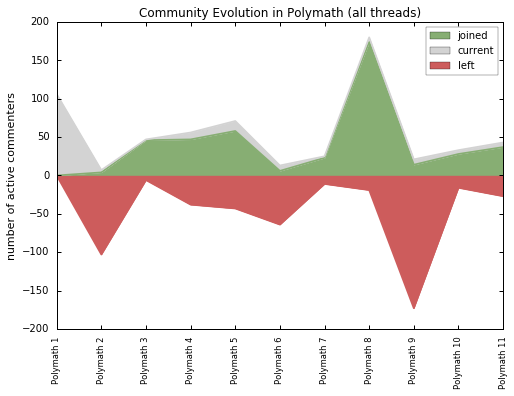

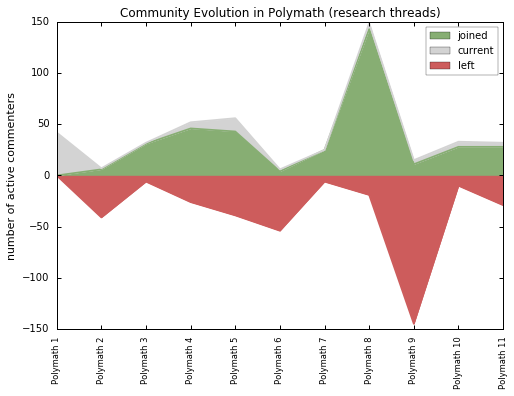

In [25]:
plot_community_evolution('Polymath', 'all threads')
plot_community_evolution('Polymath', 'research threads')

If we restrict our attention to participants that were active in at least 2 threads (less than 14% of all participants), we can start to look for patterns in how the core contributor-base evolves. A first purely qualitative representation of who participated to which projects shows both that as a long-term community Polymath is extremely small, and that the basis for the majority of this small core was largely constituted in the early stages of Polymath.

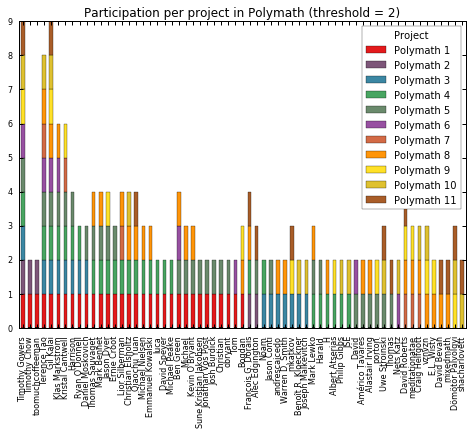

In [26]:
author_project, indices, select_2, title = project_participation_evolution(research_only=False)
plot_participation_evolution(author_project, indices, select_2, title)

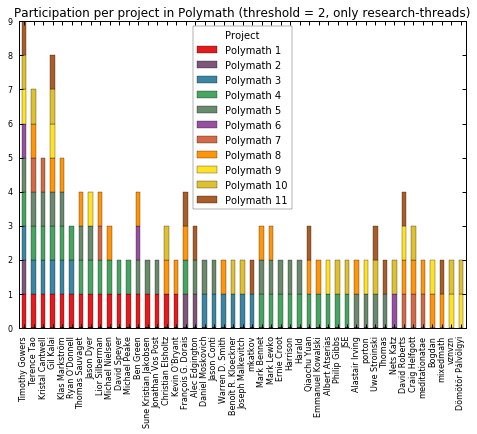

In [27]:
r_author_project, r_indices, r_select_2, title = project_participation_evolution(research_only=True)
plot_participation_evolution(r_author_project, r_indices, r_select_2, title)

To refine these insights we considered the number of comments in each project for the same set of participants. Using hierarchical linkage based on the Euclidean distance between vectors (number of comments per project per contributor and vice-versa), we identified participants and projects with similar patterns of participation. The contributors and projects were reordered on the basis of these results to reveal patterns in the heatmap included below.

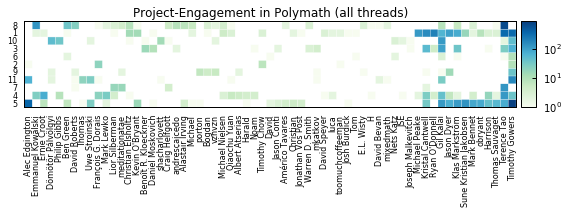

In [28]:
authors_2 = sorted([author for author, bool in select_2.items() if bool])
plot_heatmap(*general_heatmap(authors=authors_2, thread_level=False, binary=False))

This approach suggests natural grouping of the participants (recall, this is only about a small subset of all participants) based on similarity:

+ **Leaders (2):** Tao & Gowers
+ **Core-participants (11):** Peake -> Sauvaget
+ **Periphery (49):** Kowalski -> mixedmath
+ **Outsider (1):** Edgington (very active in PM5 and PM11, but not an early adopter)

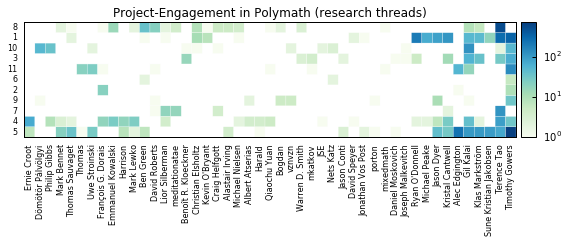

In [29]:
r_authors_2 = sorted([author for author, bool in r_select_2.items() if bool])
plot_heatmap(*general_heatmap(authors=r_authors_2, thread_level=False, binary=False, thread_type='research threads'))

The grouping that arises from restricting our attention to research-threads is slightly different:

+ **Leaders (2):** Tao & Gowers
+ **Core-participants (8):** Ryan O'Donnel -> Sune Kristian Jakobsen  
+ **Periphery (53):** Croot -> Malkevitch

One general conclusion holds for both representations, namely that the group of core participants is rather heterogeneous. Indeed more so than the participants in the periphery. **(note: isn't this to be expected that those who participated to a larger number of projects have a higher chance to be less similar (given the metric we use)**

**More importantly:** What is considered as the periphery across all projects includes some central figures of individual projects. We discuss this explicitly w.r.t. Polymath 8, but it is also true for Polymaths 4 and 5 (e.g. Ernie Croot is one of the most prominent participants to Polymath 4).

The most prominent projects according to these data are Polymath 1, 5, and to a lesser extent 4. The largest project, namely Polymath 8, is less prominent, and clearly includes fewer highly active participants from the core community of participants we identified. This suggests that limiting our attention to participants to at least two projects leaves out important contributors to Polymath 8.

A scatter-plot of the same participation-data for all participants allows us to expand our scope without sacrificing legibility.

In [30]:
author_project_bool, _, select_1, *_ = project_participation_evolution(n=1, research_only=True)
project_participation = author_project_bool.sum(axis=1)

In [31]:
authors_1 = sorted([author for author, bool in select_1.items() if bool])
author_counts,* _ = general_heatmap(authors=authors_1, thread_level=False, 
                binary=False)
author_counts_mod = author_counts.replace(0, np.NaN)
comment_participation = author_counts_mod.mean()

In [32]:
df = pd.concat([project_participation, comment_participation], axis=1).dropna()
df.columns = columns=["number of projects participated", "avg comments per project participated"]

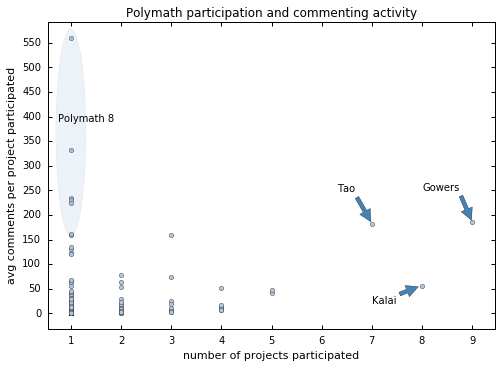

In [33]:
axes = plt.subplot()
axes.set_xticks(range(11));
axes.set_yticks(range(0, 700, 50));
axes.annotate('Gowers', xy=(9, 186), xytext=(8, 250),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Kalai', xy=(7.95, 55), xytext=(7, 20),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Tao', xy=(7, 183), xytext=(6.3, 247),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
e = mpl.patches.Ellipse(xy=(1,368), width=.6, height=420, angle=0)
e.set_alpha(.1)
e.set_facecolor('steelblue')
axes.add_artist(e)
axes.annotate('Polymath 8', xy=(1.2, 400), xytext=(.75, 390))
df.plot(kind='scatter', x='number of projects participated', y='avg comments per project participated',
            color= 'lightsteelblue', ax=axes, title="Polymath participation and commenting activity");


The above figure displays for each author the number of projects (s)he participated to (X-axis) and the avergage number of comments made to each of these projects (excluding the projects with null participation). On a total of 465 identified (non-anonymous) participants, 402 contributed to only 1 project, 32 to 2 projects, 16 to 3 projects, 10 to 4 projects, 2 to 6 projects, 1 to 8 projects, and 2 to 9 projects.

If we exclude the core-participants, there does not appear to be any marked correleation between active participation to projects and continued participation. Additionally, we can identify a group of 7 participants that were extremely active (more than 150 comments) during only one project. Further inspection of the data revealed that 6 of these participated to Polymath 8. These data-points partially explain why the largest project is under-represented in the data that reveal overlaps between projects.

Now we limit this

### TO DO

+ check if mean takes into account projects with zero participation (current version averages over threads with actual participation by replacing 0 comments by NaN)
+ "by thread" would give more balanced result since participation to large projects would give higher number of comments
+ consider "participated in at least n projects" as an alternative
+ try to use box-plots as well (per number of participations)

In [34]:
def make_network(ser, network, edge_list, thresh):
    edge_list = [(i,j, k) for (i,j,k) in edge_list if k > thresh]
    edge_dict = {(i,j): k for (i,j,k) in edge_list}
    df = DataFrame(index=ser.index, columns=ser.index)
    for (i,j) in edge_dict.keys():
        df[i][j] = edge_dict[(i,j)]
    df = df.fillna(0)
    network.add_nodes_from(ser.index)
    network.add_weighted_edges_from(edge_list)
    return network,df

def digraph_from_series_of_sets(ser, thresh=0):
    network = nx.DiGraph()
    edge_list = [(i, j, (len(ser[i] & ser[j]) / len(ser[i]))) for (i, j) in permutations(ser.index, 2)]
    return make_network(ser, network, edge_list, thresh=thresh)
    
def graph_from_series_of_sets(ser, thresh=0):
    network = nx.Graph()
    edge_list = [(i, j, (len(ser[i] & ser[j]) / len(ser[i] | ser[j]))) for (i, j) in combinations(ser.index, 2)]
    #edge_list = [(i, j, (len(ser[i] & ser[j]))) for (i, j) in combinations(ser.index, 2)]
    return make_network(ser, network, edge_list, thresh=thresh)

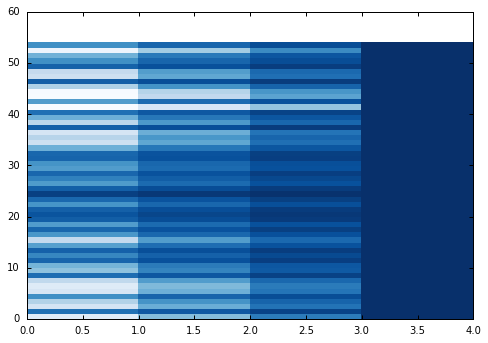

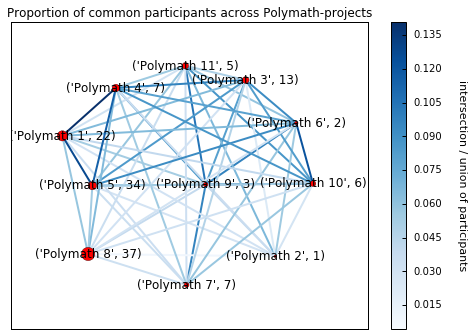

In [35]:
project_ser = get_last("all threads")[0]['all threads', 'authors (accumulated)']
project_network, project_matrix = graph_from_series_of_sets(project_ser, thresh=0)
project_nodes, project_sizes = project_ser.index.tolist(), project_ser.apply(len).tolist()
#project_nodes = [name.split()[-1] for name in project_nodes]
project_edges = project_network.edges()
project_weights = [project_network[source][dest]['weight']  for source, dest in project_edges]
maxWeight=float(max(project_weights))
project_colors = [plt.cm.Blues(weight/maxWeight) for weight in project_weights]

plt.ioff()
colors_unscaled=[tuple(map(lambda x: maxWeight*x, y)) for y in project_colors]
heatmap = plt.pcolor(colors_unscaled,cmap=plt.cm.Blues)
plt.ion()
fig,axes = plt.subplots()
nx.draw_networkx(project_network, nodelist=project_nodes,
                 edges=project_edges, node_size=project_sizes,
                 width=2, edge_color=project_colors, ax=axes)
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
plt.title("Proportion of common participants across Polymath-projects")

#add colorbar
cbar = plt.colorbar(heatmap)
cbar.ax.set_ylabel('intersection / union of participants',labelpad=25,rotation=270);

At the same time, because Polymath 8 is almost twice as large as the second largest project, these higher averages should not be taken as an indication that Polymath 8 participants were more active participants. A focus on the level of threads can reduce the size-effect of larger projects, since the variation in the size of threads (mean of 80 and std of 52, which gives a coeffient of variation of 0.65) is smaller than the variation in the size of projects (mean of 993 and std of 1175, which gives a coefficient of variation of 1.18). **Is the variation then really smaller? maybe it's just "above the mean" that projects show less variation...**

In [36]:
thread_data, *_ = general_heatmap(authors=None, binary=False, thread_level=True,
                    binary_method='average', method='ward')
thread_data = thread_data.T
thread_bool = thread_data != 0
thread_bool_sum = thread_bool.sum(axis=1)
thread_data_mean = thread_data.replace(0, np.NaN)
thread_data_mean = thread_data_mean.mean(axis=1)

In [37]:
df_threads = pd.concat([thread_bool_sum, thread_data_mean], axis=1)
df_threads.columns = ["number of threads participated", "avg comments per thread participated"]

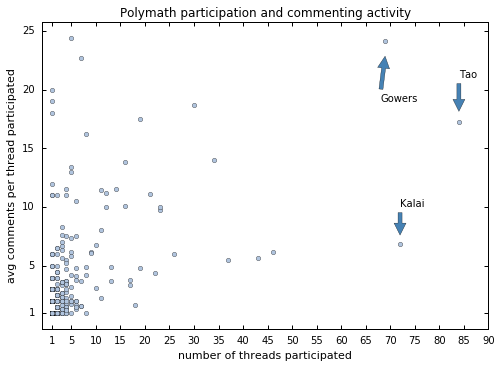

In [38]:
#z = np.polyfit(
#    x=df_threads['number of threads participated'],
#    y=df_threads["avg comments per thread participated"],
#    deg=2)
#p = np.poly1d(z)
#df_threads['trendline'] = p(df_threads["number of threads participated"])
axes = plt.subplot()
axes.set_xticks([1] + list(range(5,110,5)));
axes.set_yticks([1]+ list(range(5, 30, 5)));
axes.set_xlim(-1, 90);
axes.annotate('Gowers', xy=(69, 23), xytext=(68, 19),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Kalai', xy=(72, 7.5), xytext=(72, 10),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('Tao', xy=(84, 18), xytext=(84, 21),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
df_threads.plot(kind='scatter', x='number of threads participated', y='avg comments per thread participated',
            ax=axes, color= 'lightsteelblue', title="Polymath participation and commenting activity");
#df_threads.set_index('number of threads participated', inplace=True)
#df_threads.trendline.sort_index(ascending=False).plot(ax=axes);
#plt.gca().invert_xaxis()

The above scatter-plot displays average comments against participation, but now at the finer level of comment-threads (for a total of 137 comment-threads and the same 465 identified participants). Here too the core participants stand out. If we additionally take into account that the threads have on average 80 comments (min:1, 25% quantile: 37, 50% quantile: 91, 75% quantile: 108, max: 416), the dominant presence of Gowers and Tao can hardly be missed. Since we focus on threads instead of on projects, larger projects like Polymath 8 have, at this level of analysis, a less marked effect. Overall, the area with up to 5 comments per thread and up to 10 threads is the most populated with 403 out of 465 participants (87%; approximately the same as the number of participants that took part in only one project). Participation to only a few threads does not exclude active participation, but participation to more threads makes low participation less likely. A closer examination of the data confirms that the top-left part of the plot does not only include participants to Polymath 8, as we found for the project-level data.

**ToDo** Do paths of more than 1 really matter? (in general few components seem to have a large diameter)

In [39]:
thread_type = 'research threads'

the_graphs = get_last(thread_type)[0][thread_type, 'network'].apply(lambda netw: netw.i_graph)
#the_measures = the_graphs.apply(nx.in_degree_centrality)
#the_measures = the_graphs.apply(nx.average_node_connectivity)

60 weakly connected components
0 0
1 5
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 1
1
10 0
11 0
12 0
13 0
14 0
15 0
16 1
1
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0


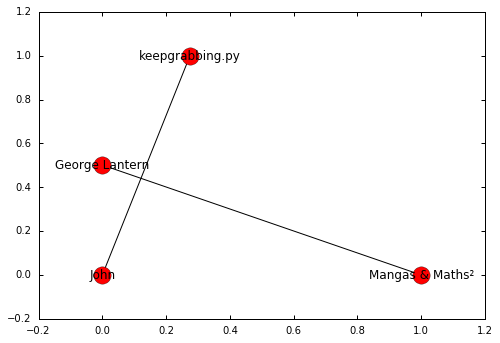

In [40]:
comp = list(nx.weakly_connected_component_subgraphs(the_graphs[7]))
print(len(comp), "weakly connected components")
for i, comp in enumerate(comp):
    comp = comp.to_undirected()
    dia = nx.diameter(comp)
    print(i, dia)
    if dia == 1:
        print(dia)
        nx.draw_networkx(comp)

In [41]:
nx.diameter(the_graphs[0].to_undirected())

NetworkXError: Graph not connected: infinite path length

In [ ]:
the_measures = the_measures.reset_index(level=0)
the_measures['ind'] = range(1,12)

In [ ]:
the_measures.columns = the_measures.columns.droplevel(1)

In [ ]:
sizes = get_last(thread_type)[0][thread_type, 'number of comments (accumulated)'].astype('int64').values

In [ ]:
groups = get_last(thread_type)[0][thread_type, 'authors (accumulated)'].apply(len).values

In [ ]:
fig, axes = plt.subplots()
sc = plt.scatter(range(1,12), the_measures[thread_type], s=sizes, c=groups, cmap=mpl.cm.GnBu)
cbar = plt.colorbar(sc)
cbar.set_label('Number of participants')
axes.set_title("Polymath projects: Connectivity, comments and participants");
axes.set_ylabel("Average node connectivity");
axes.set_xticks(range(1,12));
axes.set_yticks(np.linspace(start=0, stop=1.4, num=8));
for x, y, size in zip(range(1,12), the_measures[thread_type], sizes):
    if size >= 300:
        axes.text(x,y, size, size=9, ha='center', va='center')

#### Food for thought

+ Average length of comments vs number of comments (author and threads).
+ plot in/out-degree against number of comments (do one-time commenters get responses) (use `scatter_matrix`)
+ See if discussion happens at more than one place in thread. Do edges in tree cross?

# Investigating individual projects


In [ ]:
my_x = np.linspace

Projects can be studied from the following perspectives:

1. General features of a project, like the speed at which it grows, or the distribution of commenting-activity between the different threads.
2. A network-perspective on the relevant contributors, and either taking into account direct interactions, or co-presence in episodes (cfr. Section 4).
3. A quantitative perspective based on the number of contributions of each participant, possibly split up between threads, or between levels of comments.

We illustrate these by reconsidering Polymath 1.

In [ ]:
plot_thread_evolution("Polymath 1", compress=160, sel=[1, 2, 13, 20], sharex=True)

In [ ]:
plot_thread_evolution("Polymath 4", compress=150, sel=range(1,8), sharex=True)

In [ ]:
plot_growth('Polymath 1', thread_type='discussion threads')

**TODO** need to tweak parameters to get drawing of network more pleasant (more in the centre)

In [ ]:
draw_network("Polymath 1", 'interaction', reset=True)
draw_network("Polymath 1", 'cluster')

In [ ]:
plot_activity_degree("Polymath 1", measures=['in-degree', 'out-degree'], delete_on=0, thresh=.01)

In [ ]:
plot_centrality_measures("Polymath 1", measures=['in-degree', 'out-degree'], delete_on=0, thresh=.01, fontsize=8)

In [ ]:
project_heatmap("Polymath 1", cluster_threads=False, method='average', log=True, fontsize=6)

In [ ]:
project_heatmap("Polymath 1", cluster_threads=True, method='average', log=True, fontsize=6)

In [ ]:
project_heatmap("Polymath 4", cluster_threads=True, method='average', log=True, fontsize=8)

In [ ]:
project_heatmap("Polymath 11", cluster_threads=True, method='average', log=True, fontsize=8)

### Topics to be addressed

+ the role of hierarchical comments
+ the parellel development in PM1
+ do we see a change if we compare the different succesful projects
+ how do projects "die"
+ what's the best model to understand the role of the central figures?

    + more connected
    + more active
    + higher proportion of higher-level comments (they do reply more, sometimes even systematically)

+ the difference between research and discussion threads
+ what's the difference between PM1, PM4 and PM8 (the clearly succesfil projects)
+ what's the difference between equally large projects with different degrees of success (PM4 vs PM5)

Coefficient of variation:
 total comments                        1.916386
interaction betweenness centrality    1.797443
interaction closeness centrality      0.537735
cluster betweenness centrality        1.609066
cluster closeness centrality          0.303427
dtype: float64


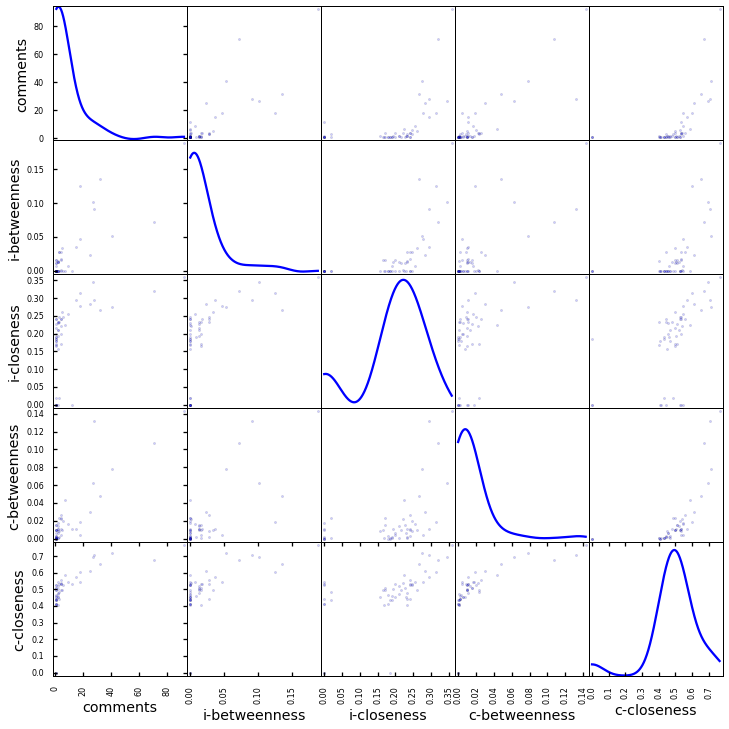

In [80]:
pm4_dat = get_project_at("Polymath 4", "research threads", -1)['network'].author_frame[['total comments', 'interaction betweenness centrality', 'interaction closeness centrality', 'cluster betweenness centrality', 'cluster closeness centrality']]
print("Coefficient of variation:\n", pm4_dat.std() / pm4_dat.mean())
from pandas.tools.plotting import scatter_matrix
pm4_dat.columns = ['comments', 'i-betweenness', 'i-closeness', 'c-betweenness', 'c-closeness']
scatter_matrix(pm4_dat, alpha=0.2, figsize=(12, 12), diagonal='kde');

## References

<div class="cite2c-biblio"></div>

## Appendix
### Overview of the threads
#### Research-threads

In [ ]:
PM_FRAME[PM_FRAME['basic', 'research']]['basic']

#### Discussion-threads

In [ ]:
PM_FRAME[~PM_FRAME['basic', 'research']]['basic']

### Identification of authors

The approach that was taken probably erred on the cautious side. **(Example: can we assume that HH, Harald and Harald Helfgott are the same?)**

In [ ]:
from access_classes import load_yaml
conversion = Series(load_yaml("author_convert.yaml")[0])
conversion